In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Helpers

In [2]:
def compress_data(df:pd.DataFrame):
    '''
    Reduce amount of movies
    Finds the optimum between :
    - Deletting as many movies as possible
    - Keeping as many views as possible
    Ranks movies by importance in terms of average of daily views
    '''

    # We normalise the views by the time the movie has been on the platform (in days)
    # That will be our movie importance value
    movie_views = df.groupby('movie_id').agg({'user_id':'count','date':'min'}).rename(columns={'user_id':'view_count','date':'release_date'}).reset_index()
    movie_views['time_available'] = df['date'].max() - movie_views['release_date']
    movie_views['time_available'] = movie_views['time_available'].apply(lambda x : x.days)
    movie_views['view_count_norm'] = movie_views['view_count'] / movie_views['time_available'].astype('int')

    # Starting with the movie that's the most successful in terms of normalised view, we count how many views remain
    # if we were to drop all the movies below (cumsum) and later compute the % in terms of all the views
    movie_views = movie_views.sort_values('view_count_norm',ascending=False)
    movie_views = movie_views.reset_index().drop(columns='index').reset_index()
    movie_views['views_left'] = movie_views['view_count'].cumsum()

    # Similarily we count how many movies are left in % (we wan't to compare how many views left with how many movies left)
    movie_views['movie_left_perc'] = (movie_views['index'] + 1) / (movie_views['index'].max() + 1)
    movie_views['views_left_perc'] = movie_views['views_left'] / movie_views['view_count'].sum()
    movie_views = movie_views.sort_values('view_count_norm')

    # Find the difference between views left (%) and movies left (%)
    movie_views['diff_views_movie'] = movie_views['views_left_perc'] - movie_views['movie_left_perc']
    # Find the maximum of this difference and remove everything up to it
    movies_to_drop = movie_views.iloc[:movie_views['diff_views_movie'].argmax()]['movie_id']
    print('Statistics')
    print(movie_views.iloc[movie_views['diff_views_movie'].argmax()][['movie_left_perc','views_left_perc']])
    del movie_views
    return df.set_index('movie_id').drop(movies_to_drop).reset_index().copy()

# I - Homemade

In [3]:
# Read processed data

df = pd.read_csv('../data/processed/training0.csv',dtype={'user_id':'int32','ratings':'int8','date':'object','movie_id':'int32'})
df['date'] = pd.to_datetime(df['date'])

# Compress data
df = compress_data(df)
#R = pd.pivot_table(df,values='ratings',index='user_id',columns='movie_id')

Statistics
movie_left_perc    0.185311
views_left_perc    0.859351
Name: 872, dtype: object


In [24]:
n_users = df['user_id'].nunique()
n_movies = df['movie_id'].nunique()
latent_space = 3
l_idx = ['l'+str(i+1) for i in range(latent_space)]

# Weights initialisation
user_w = pd.DataFrame(np.random.random((n_users,latent_space)),index=df['user_id'].unique(),columns=l_idx)
movie_w = pd.DataFrame(np.random.random((latent_space,n_movies)),index=l_idx,columns=df['movie_id'].unique())

In [25]:
# Update movie weights

counter = 0
losses = []
for movie in tqdm(df['movie_id'].unique()):
    movie_weights = movie_w.loc[:,movie].to_numpy().reshape((3,1)) # pointer
    data = df[df['movie_id'] == movie]
    data = data.merge(user_w.reset_index().rename(columns={'index':'user_id'}),
                      on='user_id')[['l1','l2','l3','ratings']]
    X = data[['l1','l2','l3']].to_numpy()
    y = data[['ratings']].to_numpy()
    for _ in range(30):
        y_hat = np.matmul(X,movie_weights)
        error = y - y_hat
        loss = np.square(error).mean() / (2*len(y))
        losses.append(loss)
        loss_p = -((X.T).dot(error)) / len(y)
        movie_weights -= loss_p*0.1
    counter += 1


100%|██████████| 873/873 [00:35<00:00, 24.26it/s]


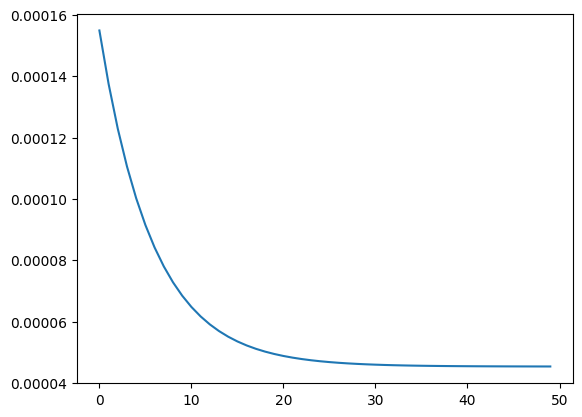

In [29]:
plt.plot(losses[100:150])

In [47]:
# Update user weights

counter = 0
losses = []
for user in tqdm(df['user_id'].unique()):
    user_weights = user_w.loc[user,:].to_numpy().reshape((3,1)) # pointer
    data = df[df['user_id'] == user]
    data = data.merge(movie_w.T.reset_index().rename(columns={'index':'movie_id'}),
                      on='movie_id')[['l1','l2','l3','ratings']]
    X = data[['l1','l2','l3']].to_numpy()
    y = data[['ratings']].to_numpy()
    for _ in range(50):
        y_hat = np.matmul(X,user_weights)
        error = y - y_hat
        loss = np.square(error).mean() / (2*len(y))
        losses.append(loss)
        loss_p = -((X.T).dot(error)) / len(y)
        user_weights -= loss_p*0.1
    counter += 1

  3%|▎         | 14192/471548 [02:17<1:13:51, 103.20it/s]


KeyboardInterrupt: 

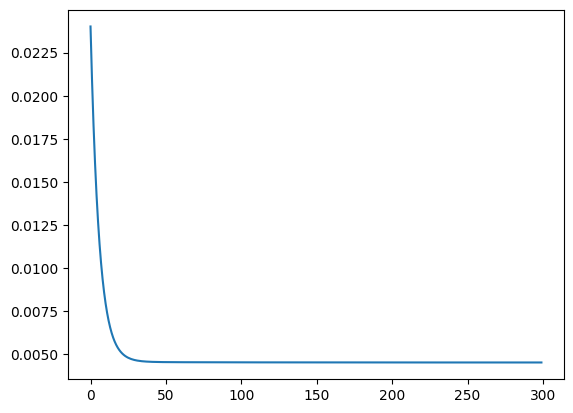

In [14]:
plt.plot(losses[600:900])

In [40]:
class alternatingRegression():
    def __init__(self, n_users, n_movies, latent_space):
        self.latent_space = latent_space
        self.l_idx = ['l'+str(i+1) for i in range(latent_space)]
        self.movie_coef_ = pd.DataFrame(np.random.random((latent_space,n_movies)),
                                  index=l_idx,columns=df['movie_id'].unique())
        self.user_coef_ = pd.DataFrame(np.random.random((n_users,latent_space)),
                                       index=df['user_id'].unique(),columns=l_idx)

    def train_movies(self,df,epochs=30,step_size=0.1):
        for movie in tqdm(df['movie_id'].unique()):
            movie_weights = self.movie_coef_.loc[:,movie].to_numpy().reshape((self.latent_space,1))
            data = df[df['movie_id']==movie]
            data = data.merge(self.user_coef_.reset_index().rename(columns={'index':'user_id'}),on='user_id')
            X = data[self.l_idx].to_numpy()
            y = data[['ratings']].to_numpy()
            for _ in range(epochs):
                y_hat = np.matmul(X,movie_weights)
                error = y - y_hat
                #loss = np.square(error).mean() / (2*y.shape[0])
                loss_p = -((X.T).dot(error)) / y.shape[0]
                movie_weights -= loss_p*step_size

    def train_users(self,df,epochs=50,step_size=0.1):
        for user in tqdm(df['user_id'].unique()):
            user_weights = self.user_coef_.loc[user,:].to_numpy().reshape((self.latent_space,1))
            data = df[df['user_id']==user]
            data = data.merge(self.movie_coef_.T.reset_index().rename(columns={'index':'movie_id'}),
                                                                   on='movie_id')
            X = data[self.l_idx].to_numpy()
            y = data[['ratings']].to_numpy()
            for _ in range(epochs):
                y_hat = np.matmul(X,user_weights)
                error = y - y_hat
                #loss = np.square(error).mean() / (2*y.shape[0])
                loss_p = -((X.T).dot(error)) / y.shape[0]
                user_weights -= loss_p * step_size

In [48]:
# Current problem : classicReg diverges !!!

n_users = df['user_id'].nunique()
n_movies = df['movie_id'].nunique()
als = alternatingRegression(n_users=n_users, n_movies=n_movies,latent_space=3)
epochs = 10
for _ in range(epochs):
    print('Training movies',end='\r')
    als.train_movies(df=df)
    movie_file = f'backup_weights/movie_weights_iteration{_}'
    als.movie_coef_.to_pickle(movie_file)

    print('Training users',end='\r')
    als.train_users(df=df)
    user_file = f'backup_weights/user_weights_iteration{_}'
    als.user_coef_.to_pickle(user_file)

100%|██████████| 873/873 [00:34<00:00, 25.63it/s]


100%|██████████| 471548/471548 [3:48:52<00:00, 34.34it/s]     


100%|██████████| 873/873 [00:25<00:00, 34.48it/s]


100%|██████████| 471548/471548 [9:10:31<00:00, 14.28it/s]     


100%|██████████| 873/873 [00:25<00:00, 34.67it/s]


100%|██████████| 471548/471548 [10:16:55<00:00, 12.74it/s]    


100%|██████████| 873/873 [00:29<00:00, 29.50it/s]


  0%|          | 752/471548 [00:06<1:11:35, 109.59it/s]


KeyboardInterrupt: 

# II - With Surprise

In [66]:
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.reader import Reader
from surprise.dataset import Dataset
from surprise.model_selection import cross_validate

In [61]:
# csv format -> user_id,ratings,date,movie_id
reader = Reader(line_format='user rating timestamp item',sep=',',skip_lines=1)
data = Dataset.load_from_file('../data/processed/training0.csv', reader=reader)

In [68]:
model = SVD()
#cross_validate(model,data,measures=['rmse','mae'])
trainset = data.build_full_trainset()
model.fit(trainset)

KeyboardInterrupt: 

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt: 
